In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# 1. Load datasets
orders = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_orders_dataset.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_customers_dataset.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_reviews_dataset.csv')
items = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_sellers_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_products_dataset.csv')

In [7]:
# 2. DATA MERGING
# ==============
df = (
    items.merge(orders, on='order_id')
    .merge(products, on='product_id')
    .merge(sellers, on='seller_id')
    .merge(reviews, on='order_id')
    .merge(customers, on='customer_id')
)


In [8]:
furniture_keywords = ['cama', 'mesa', 'sofa', 'cadeira', 'armario', 'escritorio', 'movel', 'móvel']
df['is_furniture'] = df['product_category_name'].str.contains('|'.join(furniture_keywords), case=False, na=False)
furniture_raw = df[df['is_furniture']].copy()
print(f"Original furniture data: {len(furniture_raw)}")

Original furniture data: 12824


In [9]:
df['delivery_days'] = (
    pd.to_datetime(df['shipping_limit_date']) - 
    pd.to_datetime(df['order_purchase_timestamp'])
).dt.days

In [10]:
# Convert dates and calculate delivery speed
furniture_raw['order_purchase_timestamp'] = pd.to_datetime(furniture_raw['order_purchase_timestamp'])
furniture_raw['order_delivered_customer_date'] = pd.to_datetime(furniture_raw['order_delivered_customer_date'])
furniture_raw['delivery_speed'] = (furniture_raw['order_delivered_customer_date'] - furniture_raw['order_purchase_timestamp']).dt.days

In [11]:
# 3. Filter furniture data
print("Applying filters...")
furniture_filtered = furniture_raw[
    (furniture_raw['price'].between(50, 500)) &  # Price range
    (furniture_raw['product_weight_g'] <= 10000)  # weight≤10kg
].copy()
print(f"Filtered furniture data: {len(furniture_filtered)} ({len(furniture_filtered)/len(furniture_raw):.1%})")

Applying filters...
Filtered furniture data: 8326 (64.9%)



=== Representativeness Check ===


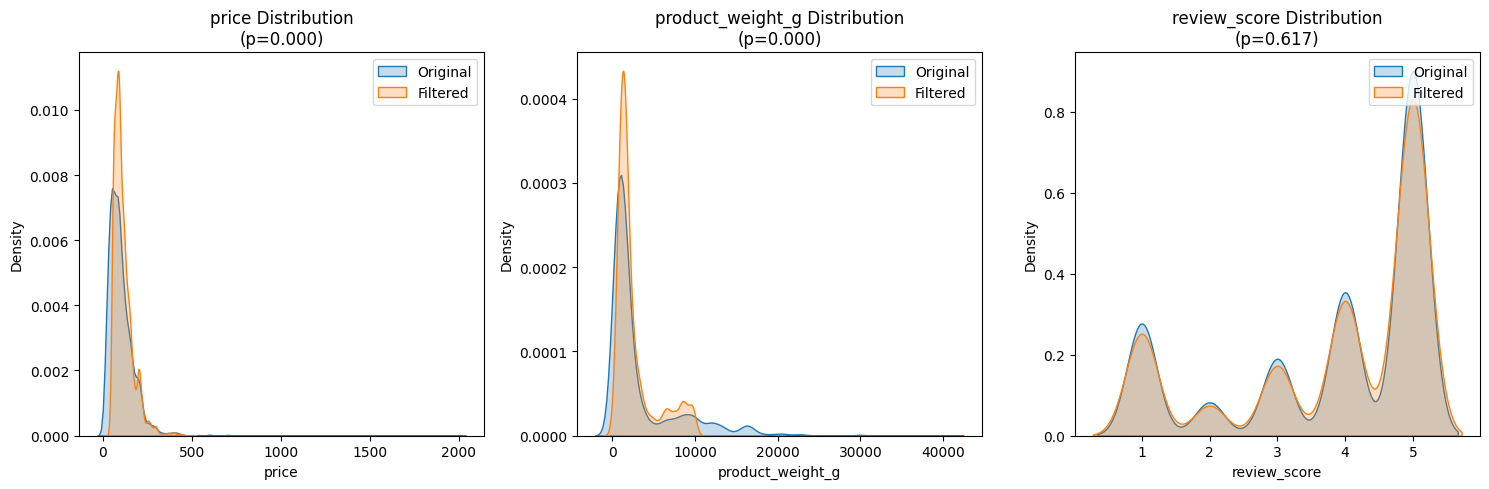

             metric  original_mean  filtered_mean  diff_pct       p_value
0             price     102.345612     112.084821  0.095160  3.135907e-23
1  product_weight_g    3338.441516    2653.111458 -0.205284  4.788122e-45
2      review_score       3.842717       3.852991  0.002674  6.171315e-01


In [12]:
# 4. representativeness check
def check_representativeness(original, filtered):
    """ Comparison of filtered and original data """
    metrics = ['price', 'product_weight_g', 'review_score']
    report = []
    
    for col in metrics:
        orig = original[col].dropna()
        filt = filtered[col].dropna()
        t_stat, p_val = stats.ttest_ind(orig, filt, equal_var=False)
        report.append({
            'metric': col,
            'original_mean': orig.mean(),
            'filtered_mean': filt.mean(),
            'diff_pct': (filt.mean() - orig.mean()) / orig.mean(),
            'p_value': p_val,
            'n_original': len(orig),
            'n_filtered': len(filt)
        })
    
    # Visualized comparison
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.kdeplot(original[col], label='Original', fill=True)
        sns.kdeplot(filtered[col], label='Filtered', fill=True)
        plt.title(f'{col} Distribution\n(p={report[i-1]["p_value"]:.3f})')
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(report)

print("\n=== Representativeness Check ===")
represent_report = check_representativeness(furniture_raw, furniture_filtered)
print(represent_report[['metric', 'original_mean', 'filtered_mean', 'diff_pct', 'p_value']])

In [13]:
# 5. EXPERIMENT DESIGN
# ==============
# Define fast sellers (top 20% fastest)
fast_threshold = furniture_filtered['delivery_speed'].quantile(0.2)
furniture_filtered['fast_seller'] = furniture_filtered['delivery_speed'] <= fast_threshold

In [14]:
# Assign groups
np.random.seed(42)
furniture_filtered['group'] = np.random.choice(
    ['test', 'control'], 
    size=len(furniture_filtered),
    p=[0.5, 0.5])

In [15]:
print(f"Valid order: {len(furniture_filtered)}条")
print(f"Size of test group: {len(furniture_filtered[furniture_filtered['group']=='test'])}条")
print(f"Size of countrol group: {len(furniture_filtered[furniture_filtered['group']=='control'])}条")

Valid order: 8326条
Size of test group: 4220条
Size of countrol group: 4106条


In [16]:
# Test group: Only include top 20 displayed items
test_group = furniture_filtered[furniture_filtered['group'] == 'test'].copy()
test_group['display_rank'] = test_group.groupby('customer_id')['fast_seller'].rank(ascending=False)
test_group = test_group[test_group['display_rank'] <= 20]

In [17]:
# Control group: All items
control_group = furniture_filtered[furniture_filtered['group'] == 'control']

In [18]:
# 6. BALANCE CHECK
# ==============
print("\n=== BALANCE CHECK ===")
print(f"Test group size: {len(test_group)}")
print(f"Control group size: {len(control_group)}")

balance_vars = ['price', 'product_weight_g', 'delivery_speed']
balance_results = []

for var in balance_vars:
    t_stat, p_val = stats.ttest_ind(
        test_group[var].dropna(),
        control_group[var].dropna(),
        equal_var=False
    )
    balance_results.append({
        'variable': var,
        'test_mean': test_group[var].mean(),
        'control_mean': control_group[var].mean(),
        'p_value': p_val
    })

print(pd.DataFrame(balance_results))


=== BALANCE CHECK ===
Test group size: 4220
Control group size: 4106
           variable    test_mean  control_mean   p_value
0             price   111.494633    112.691396  0.327048
1  product_weight_g  2611.059716   2696.330736  0.118609
2    delivery_speed    13.071309     13.087546  0.940602


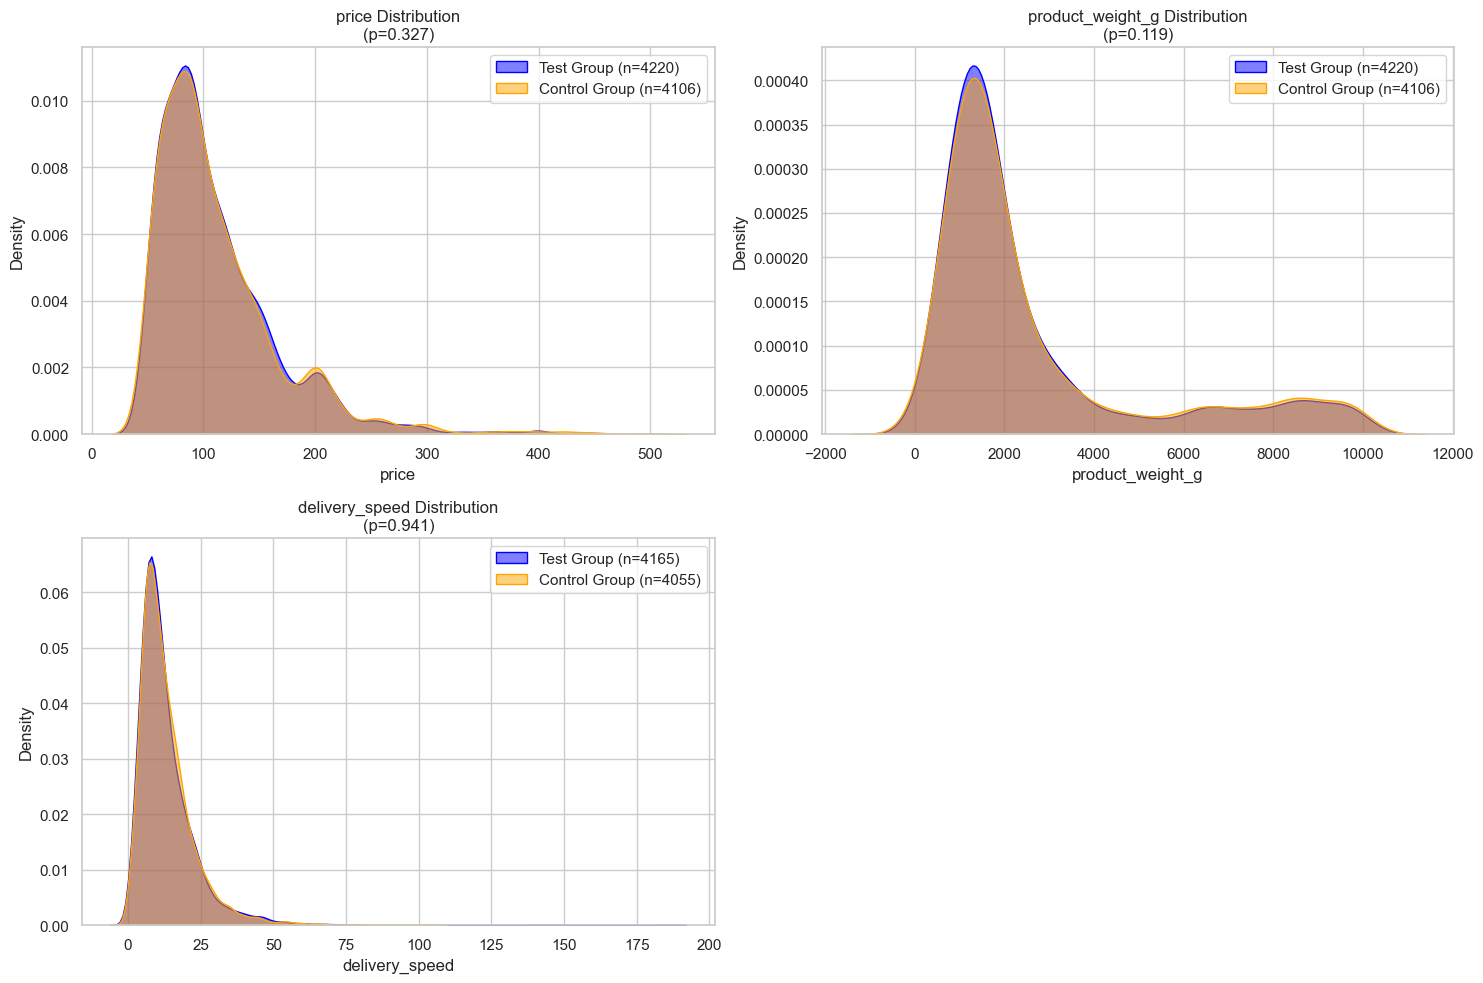

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置可视化风格
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# 选择要比较的变量
balance_vars = ['price', 'product_weight_g', 'delivery_speed']

# 创建子图
for i, var in enumerate(balance_vars, 1):
    plt.subplot(2, 2, i)
    
    # 绘制测试组分布
    sns.kdeplot(test_group[var].dropna(), 
                label=f'Test Group (n={len(test_group[var].dropna())})',
                color='blue', fill=True, alpha=0.5)
    
    # 绘制对照组分布
    sns.kdeplot(control_group[var].dropna(), 
                label=f'Control Group (n={len(control_group[var].dropna())})',
                color='orange', fill=True, alpha=0.5)
    
    # 获取p值（直接从您的平衡性检查中获取）
    p_val = [x['p_value'] for x in balance_results if x['variable'] == var][0]
    
    # 设置标题和标签
    plt.title(f'{var} Distribution\n(p={p_val:.3f})')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend()

# 调整布局
plt.tight_layout()
plt.show()

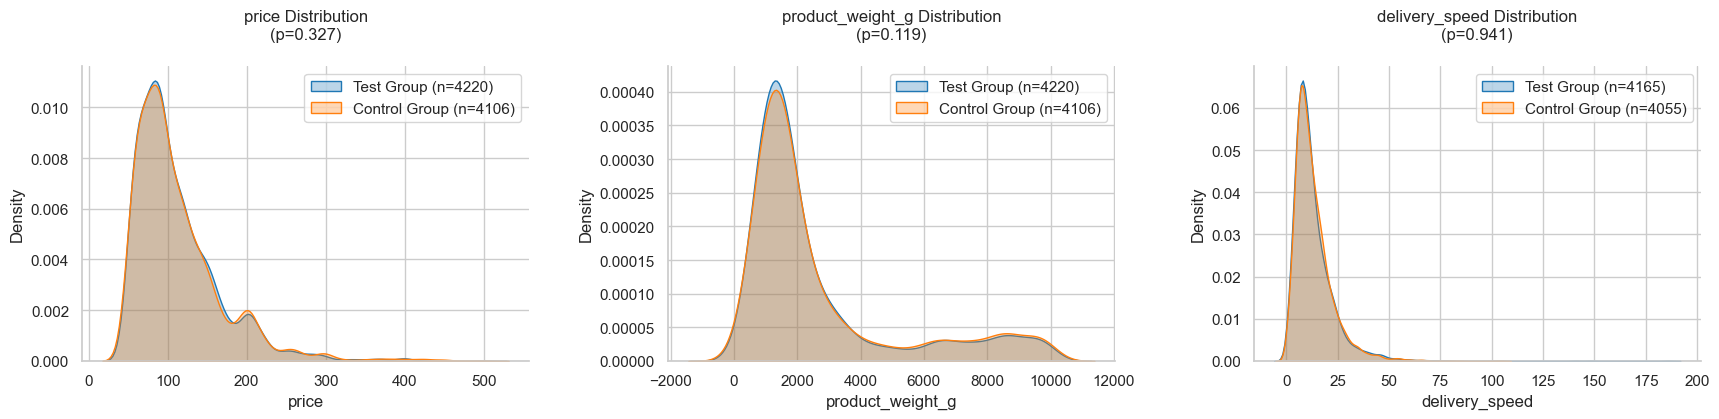

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置風格和畫布
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))  # 調整為橫向長條形畫布

# 選擇要比較的變量
balance_vars = ['price', 'product_weight_g', 'delivery_speed']

# 創建水平排列的子圖
for i, var in enumerate(balance_vars, 1):
    plt.subplot(1, 3, i)  # 1行3列
    
    # 繪製測試組分布（透明度提高到0.3）
    sns.kdeplot(test_group[var].dropna(), 
                label=f'Test Group (n={len(test_group[var].dropna())})',
                color='#1f77b4', fill=True, alpha=0.3)  # 使用seaborn默認藍色
    
    # 繪製對照組分布（透明度提高到0.3）
    sns.kdeplot(control_group[var].dropna(), 
                label=f'Control Group (n={len(control_group[var].dropna())})',
                color='#ff7f0e', fill=True, alpha=0.3)  # 使用seaborn默認橙色
    
    # 獲取p值
    p_val = [x['p_value'] for x in balance_results if x['variable'] == var][0]
    
    # 設置標題和標籤
    plt.title(f'{var} Distribution\n(p={p_val:.3f})', pad=20)
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(frameon=True, framealpha=0.8)
    
    # 移除上方和右方的邊框
    sns.despine()

# 調整子圖間距
plt.tight_layout(pad=3.0)
plt.show()